In [38]:
# print size in MB of the folder "dataset"
!du -sh dataset
!du -sh dataset_scat/fold_0
# size in MB of /content/dataset_scat/fold_0/train/0002.npy
!ls -lh /content/dataset_scat/fold_0/train/0002.npy | awk '{print $5}'



1.7G	dataset
63G	dataset_scat/fold_0
35M


In [1]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"
from google.colab import drive
import os

# mount drive
drive.mount('/content/drive', force_remount=True)

datasetdir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/"
basedir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/ScatNet/"
#basedir = "" # for local execution

# install requirements in the parent folder
requirements_path = "'/content/drive/MyDrive/Colab Notebooks/visualintelligence/requirements.txt'"
!pip install -r {requirements_path}


Mounted at /content/drive


In [2]:
#%pip install scikit-cuda cupy
import sys
!{sys.executable} -m pip install scikit-cuda cupy-cuda12x

  Using cached scikit_cuda-0.5.3-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached Mako-1.3.8-py3-none-any.whl.metadata (2.9 kB)
  Using cached pycuda-2024.1.2.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.4/92.4 kB 9.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660605 sha256=bd98be4cc12dd717e505d131adeb92d611d82d01ced4907dfaeb55c5ab46acff
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [3]:
# install kymatio from souce
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!git clone https://github.com/kymatio/kymatio
!cd kymatio && pip install -r requirements.txt && python setup.py install

fatal: destination path 'kymatio' already exists and is not an empty directory.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.io.image import decode_jpeg, read_file
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
from sklearn.model_selection import StratifiedKFold
import random
from PIL import Image
import torch.multiprocessing as mp
from functools import lru_cache
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from collections import OrderedDict
from functools import lru_cache
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile
from functools import lru_cache
import json

In [5]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)
print(f"Number of cores: {num_cores}")

Using cuda
Number of cores: 2


In [6]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA
DATASET_PERCENTAGE = 0.2

In [7]:
with ZipFile(datasetdir+"dataset.zip", "r") as zip_ref:

    zip_ref.extractall()

# move folders to the right place
os.makedirs("dataset", exist_ok=True)
shutil.move(ADENOCARCINOMA, "dataset")
shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
shutil.move(BENIGN, "dataset")

'dataset/benign'

Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
      filename           class
7666  4063.jpg  adenocarcinoma
9467  0588.jpg  adenocarcinoma
215   4576.jpg          benign
8332  0253.jpg  adenocarcinoma
2730  2496.jpg          benign
Number of files in the dataset: 2000


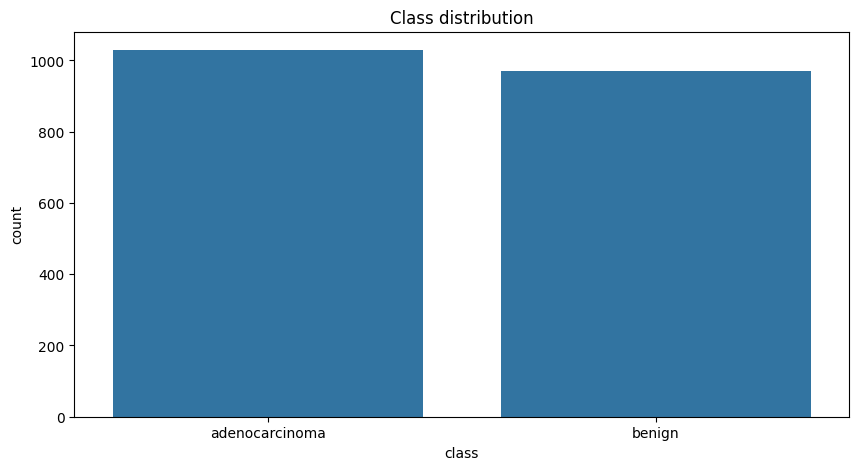

In [8]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"dataset/{class_0}")
allFilesClass1 = os.listdir(f"dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# keep DATASETPERCENTAGE data
df = df.sample(frac=DATASET_PERCENTAGE)

print(df.head())
print(f"Number of files in the dataset: {len(df)}")

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")
plt.show()

In [9]:
# Performing a stratified k-folds subdivision
KFOLDS = 10
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
skf.get_n_splits(df["filename"], df["class"])

# Storing indexes to reuse them later
train_indexes = []
val_indexes = []
for train_index, val_index in skf.split(df["filename"], df["class"]):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])

for i in range(KFOLDS):
    #train_splits[f"train_{i}"] = train_indexes[i]
    #val_splits[f"val_{i}"] = val_indexes[i]
    # move 80% of train indexes to val
    perc = int(0.2 * len(train_indexes[i]))
    train_splits[f"train_{i}"] = train_indexes[i][:perc]
    val_splits[f"val_{i}"] = np.concatenate((train_indexes[i][perc:], val_indexes[i]))


# Saving the splits
train_splits.to_csv(basedir + "train_splits.csv", index=False)
val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [10]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")
print(train_splits.head())
print(val_splits.head())

   train_0  train_1  train_2  train_3  train_4  train_5  train_6  train_7  \
0        0        0        1        0        0        0        0        0   
1        1        1        2        1        1        2        1        1   
2        2        2        5        2        2        3        2        2   
3        3        3        6        3        3        4        3        3   
4        4        4        7        4        4        5        4        4   

   train_8  train_9  
0        0        0  
1        1        1  
2        3        2  
3        4        3  
4        5        4  
   val_0  val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9
0    403    391    401    405    402    413    395    398    399    396
1    404    392    402    406    404    414    396    399    400    398
2    405    393    403    407    405    415    397    400    401    399
3    406    394    404    409    406    416    398    401    402    400
4    407    395    406    410    407    417  

In [11]:
TARGET_IMAGE_SIZE = 768

In [12]:
class RawDataset(Dataset):
    def __init__(self, df, folder_path, transform=None):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["filename"]
        img_class = self.df.iloc[idx]["class"]
        img_path = os.path.join(self.folder_path, img_class, img_name)

        # Load and cache image
        #image = Image.open(img_path).convert("RGB")
        #image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
        data = read_file(img_path)
        image = decode_jpeg(data, device=device).float()  / 255
        label = 1 if img_class == class_1 else 0
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


In [13]:
def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE):
    """Calculate mean and std for a specific fold"""

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    train_dataset = RawDataset(train_df, "dataset")

    # Calculate mean and std
    channels_sum = torch.zeros(3, device=device)
    channels_squared_sum = torch.zeros(3, device=device)
    num_batches = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset, batch_size=32,
        ),
        desc="Calculating dataset statistics",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [14]:
#fold_stats = {}
#for fold in range(KFOLDS):
#    train_idx = train_splits[f"train_{fold}"].values
#    val_idx = val_splits[f"val_{fold}"].values
#
#    # Calculate statistics for this fold
#    mean, std = calculate_fold_stats(df, train_idx)
#    fold_stats[fold] = {"mean": mean, "std": std}
#
## Save fold statistics
#with open(basedir+"fold_stats.json", "w") as f:
#    json.dump(
#        {
#            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
#            for k, v in fold_stats.items()
#        },
#        f,
#    )
#    print("Fold statistics saved to fold_stats.json")

In [19]:
# load fold statistics
with open(basedir+"fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.7102381587028503, 0.5774946212768555, 0.8308100700378418], 'std': [0.16012145578861237, 0.2054198533296585, 0.11785192042589188]}, '1': {'mean': [0.7153916358947754, 0.5793658494949341, 0.827663779258728], 'std': [0.16000042855739594, 0.20650869607925415, 0.11846884340047836]}, '2': {'mean': [0.7124004364013672, 0.57718825340271, 0.8294227123260498], 'std': [0.16072724759578705, 0.2046387791633606, 0.11855459958314896]}, '3': {'mean': [0.7118358016014099, 0.5754610300064087, 0.8304902911186218], 'std': [0.1610608547925949, 0.2065279632806778, 0.11821676045656204]}, '4': {'mean': [0.7119261622428894, 0.577910304069519, 0.830891489982605], 'std': [0.1604490578174591, 0.20607998967170715, 0.11756657809019089]}, '5': {'mean': [0.716543436050415, 0.5777392983436584, 0.8279311060905457], 'std': [0.15970361232757568, 0.20486460626125336, 0.11915037781000137]}, '6': {'mean': [0.7131673693656921, 0.5764185190200806, 0.8261240720748901], 'std': [0.16096830368041992, 0.207371056

In [28]:
from kymatio.torch import Scattering2D
scat_transform = Scattering2D(J=2, shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), backend='torch_skcuda')
scat_transform = scat_transform.to(device)

/usr/local/lib/python3.10/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [35]:

# make dataset_scat dir if does not exist
os.makedirs("dataset_scat", exist_ok=True)

# compute scattering transform and save to file

def compute_scat_transform(row, fold, isTrain = True):
    img_name, img_class = row[1], row[2]
    img_path = os.path.join("dataset", img_class, img_name)
    data = read_file(img_path)
    image = decode_jpeg(data, device=device).float() / 255
    # show the image
    #shown_image = image.permute(1, 2, 0).cpu().numpy()
    #plt.imshow(shown_image)
    #plt.title(f"Class: {img_class}")
    #plt.axis("off")
    #plt.show()
    # apply normalization
    transform = transforms.Compose( [ transforms.Normalize(mean=mean, std=std), ] )
    transformed_image = transform(image)
    #show the image
    #shown_image = transformed_image.permute(1, 2, 0).cpu().numpy()
    #plt.imshow(shown_image)
    #plt.title(f"Class: {img_class}")
    #plt.axis("off")
    #plt.show()
    result = scat_transform(transformed_image)
    des_folder = "train" if isTrain else "val"
    np.save("dataset_scat/fold_" + str(fold) + f"/{des_folder}/" + img_name.split(".")[0] + ".npy", result.cpu().numpy())

for fold in range(KFOLDS):
    print(f"Processing fold {fold}")
    os.makedirs("dataset_scat/fold_" + str(fold), exist_ok=True)
    os.makedirs("dataset_scat/fold_" + str(fold) + "/train", exist_ok=True)
    os.makedirs("dataset_scat/fold_" + str(fold) + "/val", exist_ok=True)
    train_idx = train_splits[f"train_{fold}"].values
    val_idx = val_splits[f"val_{fold}"].values
    mean = fold_stats[f"{fold}"]["mean"]
    std = fold_stats[f"{fold}"]["std"]

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]


    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        compute_scat_transform(row, fold, isTrain=True)

    for row in tqdm(val_df.itertuples(), total=len(val_df)):
        compute_scat_transform(row, fold, isTrain=False)




print("Done")




Processing fold 0


  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Processing fold 1


  0%|          | 0/360 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
class ScatDataset(Dataset):
    def __init__(self, df, folder_path, transform=None):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["filename"]
        img_class = self.df.iloc[idx]["class"]
        img_path = os.path.join(self.folder_path, img_name)

        # read npy form file
        image = np.load(img_path.split(".")[0] + ".npy")
        image = torch.tensor(image, dtype=torch.float32)

        label = 1 if img_class == class_1 else 0
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


In [48]:
def create_dataloaders(
    df, train_idx, val_idx, fold, batch_size=32
):
    """Create normalized dataloaders for a specific fold"""

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_path = f"dataset_scat/fold_{fold}/train"
    val_path = f"dataset_scat/fold_{fold}/val"

    train_dataset = ScatDataset(train_df, train_path)
    val_dataset = ScatDataset(val_df, val_path)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [49]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, "0")

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 12
Val loader length: 52


In [50]:
# benchmark the dataloaders
def benchmark_dataloader(loader, num_epochs=1):
    for epoch in range(num_epochs):
        for i, (data, target) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
            pass

benchmark_dataloader(train_loader, num_epochs=1)
benchmark_dataloader(val_loader, num_epochs=1)

Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
from kymatio.torch import Scattering2D

# apply Scattering to an image
scattering = Scattering2D(J=5,
                          shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
                          backend='torch_skcuda',
                          max_order=1)
scattering = scattering.to(device)

images, labels = next(iter(train_loader))
print(images.shape)


""" Output
torch.Size([32, 3, 768, 768])
torch.Size([32, 3, 81, 192, 192])
"""


In [ ]:
result = scattering(images)
print(result.shape)

In [56]:
from kymatio.torch import Scattering2D

# Create a ScatNet
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        #self.scattering = Scattering2D(J=2, shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), backend='torch_skcuda')
        # pool
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(3 * 81, 2), # J = 2
            #nn.Linear(3 * 1401, 2), # J = 7
        )

    def forward(self, x):
        #print(f"forward: {x.shape}")
        #x = self.scattering(x)
        #print(f"scattering: {x.shape}")
        x = self.global_pool(x)
        #print(f"global_pool: {x.shape}")
        x = torch.flatten(x, 1)
        #print(f"flatten: {x.shape}")
        x = self.classifier(x)
        #print(f"classifier: {x.shape}")
        return x
""" J = 2
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 81, 192, 192])
global_pool: torch.Size([1, 3, 81, 1, 1])
flatten: torch.Size([1, 243])
"""
""" J = 3
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 217, 96, 96])
global_pool: torch.Size([1, 3, 217, 1, 1])
flatten: torch.Size([1, 651])
"""
""" J = 4
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 417, 48, 48])
global_pool: torch.Size([1, 3, 417, 1, 1])
flatten: torch.Size([1, 1251])
"""
""" J = 5
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 681, 24, 24])
global_pool: torch.Size([1, 3, 681, 1, 1])
flatten: torch.Size([1, 2043])
"""
""" J = 6
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 1009, 12, 12])
global_pool: torch.Size([1, 3, 1009, 1, 1])
flatten: torch.Size([1, 3027])
"""
""" J = 7
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
scattering: torch.Size([1, 3, 1401, 6, 6])
global_pool: torch.Size([1, 3, 1401, 1, 1])
flatten: torch.Size([1, 4203])
"""

model = ImageClassifier().to(device)

In [ ]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image)
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 3, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("profile"),
) as prof:
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        prof.step()
        if prof.step_num == 40:
            break

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
print("Profiling finished.")


In [52]:
# Defining the operations to do in a training step
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    # Put model in train mode
    model.train()
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Send data to target device
        X = img.to(device)
        y = label.to(device)
        # Forward pass
        y_pred = model(X)
        # Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        # Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [53]:
# Defining the operations to do in a validation step
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    # Put model in eval mode
    model.eval()
    # Setup validation loss and validation accuracy values
    val_loss, val_acc = 0, 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for _, (img, label) in enumerate(dataloader):
            # Send data to target device
            X = img.to(device)
            y = label.to(device)
            # Forward pass
            val_pred_logits = model(X)
            # Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()
            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [54]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,  # Early stopping patience
    min_delta: float = 0.001,  # Minimum improvement required
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, verbose="True"
    )

    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                #"model": ImageClassifier(),
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir+"checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [57]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 5
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6757 | train_acc: 0.7109 | val_loss: 0.6719 | val_acc: 0.8389
Epoch: 2 | train_loss: 0.6572 | train_acc: 0.7682 | val_loss: 0.6590 | val_acc: 0.8191
Epoch: 3 | train_loss: 0.6434 | train_acc: 0.7682 | val_loss: 0.6471 | val_acc: 0.8233
Epoch: 4 | train_loss: 0.6289 | train_acc: 0.7708 | val_loss: 0.6357 | val_acc: 0.8480


KeyboardInterrupt: 

In [ ]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

In [ ]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir +"results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

In [ ]:
results_from_csv = pd.read_csv(basedir+"results_df_0.csv")

In [ ]:

# Setup a plot
plt.figure(figsize=(15,7))

# Plot loss
plt.subplot(1,2,1)
plt.plot(results_from_csv["epochs"],results_from_csv["train_loss"],label="train_loss")
plt.plot(results_from_csv["epochs"],results_from_csv["val_loss"],label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(results_from_csv["epochs"],results_from_csv["train_acc"],label="train_accuracy")
plt.plot(results_from_csv["epochs"],results_from_csv["val_acc"],label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1,10):
    # Keeping the split
    train_str = "train_"+str(i)
    val_str = "val_"+str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()
    # Train model
    model_results = train(model=model,
                          train_dataloader=train_loader,
                          val_dataloader=val_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=NUM_EPOCHS,
                          split=i)
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir+"results_df_"+str(i)+".csv"
    results_df.to_csv(results_df_name)

In [ ]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=torch.device(device))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [ ]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1

accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")